<a href="https://colab.research.google.com/github/imaizumi0302/store_sales_prediction/blob/main/store_sales_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gc
import os
import datetime as dt
import optuna


import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import root_mean_squared_error


import xgboost as xgb
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,OneHotEncoder
import shap


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#trainデータ読み込み
train = pd.read_csv("/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/train.csv")
print(train.shape)
train.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
#storeデータ読み込み
store = pd.read_csv("/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/stores.csv")
print(store.shape)
store.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
oil = pd.read_csv("/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/oil.csv")
print(oil.shape)
oil.head()

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [7]:
# データのそもそもない土日祝日などを補間
oil["date"] = pd.to_datetime(oil["date"])
oil = (
    oil.set_index("date")
    .resample("D")
    .ffill()
)

In [8]:
oil["dcoilwtico"] = oil['dcoilwtico'].ffill()
oil["dcoilwtico"] = oil['dcoilwtico'].bfill()

In [9]:
holidays = pd.read_csv("/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/holidays_events.csv")
print(holidays.shape)
holidays.tail()

(350, 6)


,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [10]:
print(store["city"].unique())
print(store["state"].unique())
print(holidays["locale"].unique())
print(holidays["locale_name"].unique())

['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
['Local' 'Regional' 'National']
['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']


In [11]:
#テストデータ読み込み
test = pd.read_csv("/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/test.csv")
print(test.shape)
print(test.head())

(28512, 5)
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0


# 学習データとテストデータを結合

In [12]:
df = pd.concat([train, test], ignore_index=True)


In [13]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [14]:
df.shape

(3029400, 6)

#データフレーム結合&データタイプ変換


In [15]:
df = pd.merge(df,store,on="store_nbr",how="left")
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [16]:
#データタイプをdatetimeに変換
df["date"] = pd.to_datetime(df["date"])

# object型をcategory型に変換
features_type_changed = ["family","city","state","type"]
for col in features_type_changed:
  df[col] = df[col].astype("category")

In [17]:
df = pd.merge(df,oil,on="date",how="left")
print(df.shape)
df.head()

(3029400, 11)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14


In [18]:
holidays.dtypes

,0
date,object
type,object
locale,object
locale_name,object
description,object
transferred,bool


In [19]:
# holidaysデータのタイプ変換
holidays["date"] = pd.to_datetime(holidays["date"])

# object型をcategory型に変換
holidays_features_type_changed = ["type","locale","locale_name"]
for col in holidays_features_type_changed:
  holidays[col] = holidays[col].astype("category")

#データ探索

In [20]:
df.dtypes

,0
id,int64
date,datetime64[ns]
store_nbr,int64
family,category
sales,float64
onpromotion,int64
city,category
state,category
type,category
cluster,int64


In [21]:
df.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,28512
onpromotion,0
city,0
state,0
type,0
cluster,0


In [22]:
#各変数のユニークな値の数を確認

family_nunique = df["family"].nunique()
store_nbr_nunique = df["store_nbr"].nunique()
date_nunique = df["date"].nunique()
onpromotion_nunique = df["onpromotion"].nunique()
type_nunique = df["type"].nunique()
cluster_nunique = df["cluster"].nunique()

print("familyのユニーク数:", family_nunique)
print("store_nbrのユニーク数:", store_nbr_nunique)
print("dateのユニーク数:", date_nunique)
print("onpromotionのユニーク数:", onpromotion_nunique)
print("typeのユニーク数:", type_nunique)
print("clusterのユニーク数:", cluster_nunique)

familyのユニーク数: 33
store_nbrのユニーク数: 54
dateのユニーク数: 1700
onpromotionのユニーク数: 367
typeのユニーク数: 5
clusterのユニーク数: 17


In [23]:
#各変数のユニークな値の種類を確認

family_unique = df["family"].unique()
store_nbr_unique = df["store_nbr"].unique()
date_unique = df["date"].unique()
onpromotion_unique = df["onpromotion"].unique()

print("familyのユニークの種類:", family_unique)
print("store_nbrのユニークの種類:", store_nbr_unique)
print("dateのユニークの種類:", date_unique)
print("onpromotionのユニークの種類:", onpromotion_unique)

familyのユニークの種類: ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', ..., 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
Length: 33
Categories (33, object): ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS',
                          'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
store_nbrのユニークの種類: [ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
dateのユニークの種類: <DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00',
 ...
 '2017-08-22 00:00:00', '2017-08-23 00:00:00', '2017-08-24 00:00:00',
 '2017-08-25 00:00:00', '2017-08-26 00:00:00', '2017-08-27 00:00:00',
 '2017-08-28 00:00:00', '2017-08-29 00:00:00', '2017-08-

In [24]:
# 最初の日と最後の日を取得
start_date = df["date"].min()
end_date = df["date"].max()

print("最初の日:", start_date)
print("最後の日:", end_date)

最初の日: 2013-01-01 00:00:00
最後の日: 2017-08-31 00:00:00


In [25]:
df.groupby("family")["date"].count()

,date
family,
AUTOMOTIVE,91800
BABY CARE,91800
BEAUTY,91800
BEVERAGES,91800
BOOKS,91800
BREAD/BAKERY,91800
CELEBRATION,91800
CLEANING,91800
DAIRY,91800


In [26]:
df.describe()

,id,date,store_nbr,sales,onpromotion,cluster,dcoilwtico
count,3.029400e+06,3029400,3.029400e+06,3.000888e+06,3.029400e+06,3.029400e+06,3.029400e+06
mean,1.514700e+06,2015-05-02 08:56:11.294118144,2.750000e+01,3.577757e+02,2.643830e+00,8.481481e+00,6.773231e+01
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01
25%,7.573498e+05,2014-03-02 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.640750e+01
50%,1.514700e+06,2015-05-02 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.328000e+01
75%,2.272049e+06,2016-07-01 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00,1.300000e+01,9.571000e+01
max,3.029399e+06,2017-08-31 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02
std,8.745126e+05,NaN,1.558579e+01,1.101998e+03,1.233287e+01,4.649735e+00,2.562445e+01


In [27]:
df["onpromotion"].unique()

array([  0,   3,   5,   1,  56,  20,  19,   2,   4,  18,  17,  12,   6,
         7,  10,   9,  50,   8,  16,  42,  51,  13,  15,  47,  21,  40,
        37,  54,  24,  58,  22,  59,  11,  45,  25,  55,  26,  43,  35,
        14,  28,  46,  36,  32,  53,  57,  27,  39,  41,  30,  29,  49,
        23,  48,  44,  38,  31,  52,  33,  34,  61,  60, 116,  86,  73,
       113, 102,  68, 104,  93,  70,  92, 121,  72, 178, 174, 161, 118,
       105, 172, 163, 167, 142, 154, 133, 180, 181, 173, 165, 168, 186,
       140, 149, 145, 169, 188,  62,  84, 111,  65, 107,  63, 101,  87,
       125,  94, 114, 171, 153, 170, 166, 141, 155, 179, 192, 131, 147,
       151, 189,  79,  74, 110,  64,  67,  99, 123, 157, 117, 150, 182,
       162, 160, 194, 135, 190,  69, 108,  89, 126, 156, 103, 146, 132,
       177, 164, 176, 112,  75, 109,  91, 128, 175, 187, 148, 137, 184,
       196, 144, 158, 119, 106,  66, 100,  90, 120, 115,  98, 159, 152,
       185, 139, 143,  80, 124,  71, 134, 193,  78,  88, 122, 13

In [28]:
#onpromotionの数ごとの売り上げ確認
df.groupby("onpromotion")["sales"].mean()

,sales
onpromotion,
0,158.246681
1,467.556532
2,662.925632
3,871.408092
4,969.916135
...,...
719,6681.000000
720,6154.000000
722,5846.000000


In [29]:
#stateとcityごとにカウント
df.groupby(["state","city"])["store_nbr"].count()

state       city         
Azuay       Ambato                0
            Babahoyo              0
            Cayambe               0
            Cuenca           168300
            Daule                 0
                              ...  
Tungurahua  Quevedo               0
            Quito                 0
            Riobamba              0
            Salinas               0
            Santo Domingo         0
Name: store_nbr, Length: 352, dtype: int64

In [30]:
#typeごとの売り上げ確認
df.groupby("type")["sales"].mean()

,sales
type,
A,705.878743
B,326.739714
C,197.263301
D,350.979407
E,269.121301


In [31]:
#clusterごとの売り上げ確認
df.groupby("cluster")["sales"].mean()

,sales
cluster,
1,326.163967
2,260.170621
3,194.416262
4,296.572872
5,1117.245254
6,342.661732
7,139.261863
8,647.377856
9,274.968339


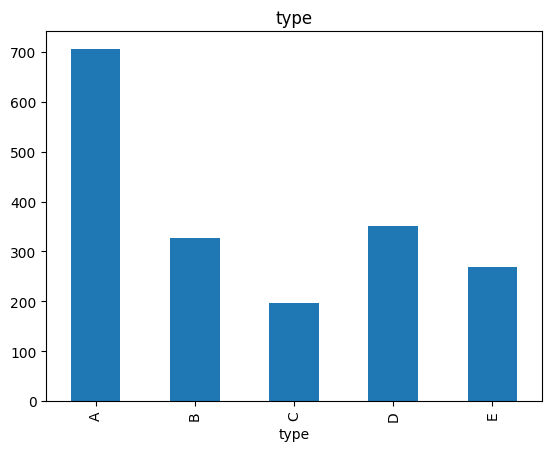

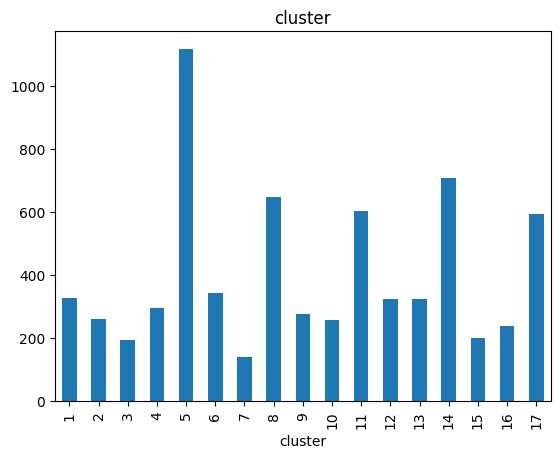

In [32]:
#typeごとの売り上げとclusterごとの売り上げをバーチャートで描画
for col in ["type","cluster"]:
  df.groupby(col)["sales"].mean().plot(kind="bar")
  plt.title(col)
  plt.show()

#特徴量エンジニアリング


ここでは、確認用にデータフレームを用意しひとつひとつ関数を作成し、実行していく。
あとで、最終的な本番用のデータにまとめて関数を適用する。

In [33]:
df.dtypes

,0
id,int64
date,datetime64[ns]
store_nbr,int64
family,category
sales,float64
onpromotion,int64
city,category
state,category
type,category
cluster,int64


In [34]:
# 確認・可視化用データフレーム作成
df_tmp = df.copy()

## foldに依存しない特徴量

### oilの移動平均を作成


In [35]:
def add_oil_features(df):
    df = df.sort_values("date").copy()

    df["oil_mean_30"]  = df["dcoilwtico"].rolling(30, min_periods=1).mean()
    df["oil_mean_90"]  = df["dcoilwtico"].rolling(90, min_periods=1).mean()
    df["oil_mean_180"] = df["dcoilwtico"].rolling(180, min_periods=1).mean()

    return df

In [36]:
df_tmp = add_oil_features(df_tmp)
df_tmp.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,oil_mean_30,oil_mean_90,oil_mean_180
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,93.14,93.14,93.14
1194,1194,2013-01-01,42,CELEBRATION,0.0,0,Cuenca,Azuay,D,2,93.14,93.14,93.14,93.14
1193,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Cuenca,Azuay,D,2,93.14,93.14,93.14,93.14
1192,1192,2013-01-01,42,BOOKS,0.0,0,Cuenca,Azuay,D,2,93.14,93.14,93.14,93.14
1191,1191,2013-01-01,42,BEVERAGES,0.0,0,Cuenca,Azuay,D,2,93.14,93.14,93.14,93.14


### 日付データの特徴量作成

In [37]:
def add_date_features(df):
  # store_nbrとfamilyごとに日付順にソート
  df = df.sort_values(["store_nbr", "family", "date"])

  # 日付を分解して特徴量に
  df["year"] = df["date"].dt.year
  df["month"] = df["date"].dt.month
  df["day"] = df["date"].dt.day

  #曜日を分解して特徴量に(0が月曜日)
  df["weekday"] = df["date"].dt.weekday

  # 土日フラグを作成
  df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

  return df

In [38]:
df_tmp = add_date_features(df_tmp)
df_tmp.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,oil_mean_30,oil_mean_90,oil_mean_180,year,month,day,weekday,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,93.14,93.14,93.14,2013,1,1,1,0
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,93.14,93.14,93.14,93.14,2013,1,2,2,0
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,92.97,92.97,92.97,92.97,2013,1,3,3,0
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,93.12,93.12,93.12,93.12,2013,1,4,4,0
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,93.12,93.12,93.12,93.12,2013,1,5,5,1


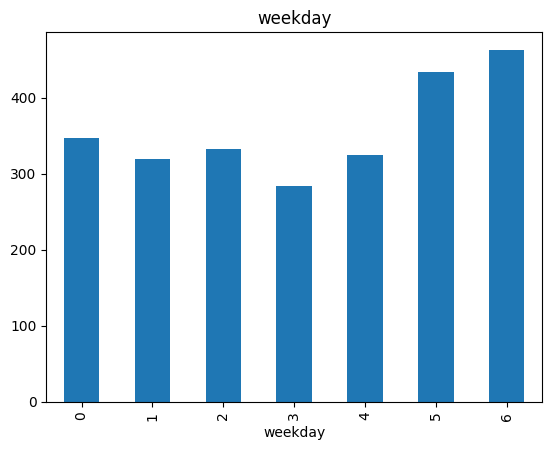

In [39]:
#曜日ごとの売り上げ平均を確認
df_tmp.groupby("weekday")["sales"].mean().plot(kind="bar")
plt.title("weekday")
plt.show()

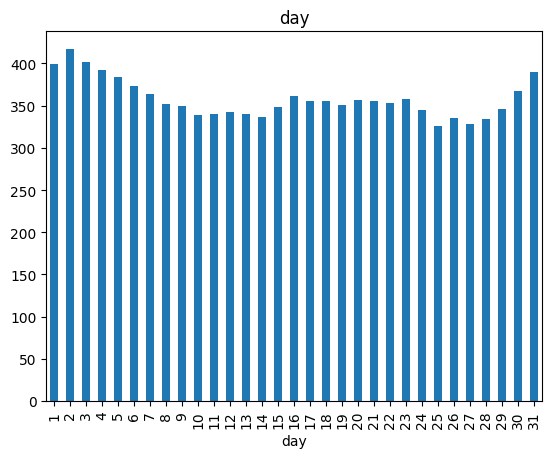

In [40]:
#日付ごとの売り上げ平均を確認
df_tmp.groupby("day")["sales"].mean().plot(kind="bar")
plt.title("day")
plt.show()

### 祝日フラグ付け

In [41]:
holidays.dtypes

,0
date,datetime64[ns]
type,category
locale,category
locale_name,category
description,object
transferred,bool


In [42]:
holidays_tmp = holidays.copy()

In [43]:
holidays_tmp

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [44]:
holidays_tmp["type"].unique()

['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event']
Categories (6, object): ['Additional', 'Bridge', 'Event', 'Holiday', 'Transfer', 'Work Day']

In [45]:
holiday_types = ['Holiday', 'Transfer', 'Bridge', 'Additional']


def make_holiday_flag(holidays):
  holidays = holidays.copy()

  holidays['date'] = pd.to_datetime(holidays['date'])

  holidays['is_holiday'] = (holidays['type'].isin(holiday_types) &(holidays['transferred'] == False)).astype(int)

  # regionalの祝日のみを格納したデータフレームを作成
  regional = holidays[
      (holidays['locale'] == 'Regional') & (holidays['is_holiday'] == 1)][['date', 'locale_name']].drop_duplicates()

  #  列名を一致させる（locale_name を state としてマージできるようにする）
  regional = regional.rename(columns={'locale_name': 'state'})


  # nationalの祝日のみを格納したデータフレームを作成
  national = holidays[(holidays['locale']=='National') & (holidays['is_holiday']==1)][['date']].drop_duplicates()


  # local (city)
  local = holidays[(holidays['locale']=='Local') & (holidays['is_holiday']==1)][['date','locale_name']].drop_duplicates()
  local = local.rename(columns={'locale_name':'city'})


  # workdayフラグも作成
  workday = holidays[holidays['type'] == 'Work Day'][['date']].drop_duplicates()




  return holidays,regional,national,local,workday


In [46]:
holidays_tmp,regional_tmp,national_tmp,local_tmp,workday_tmp = make_holiday_flag(holidays_tmp)

In [47]:
holidays_tmp[holidays_tmp["type"] == "Work Day"]

,date,type,locale,locale_name,description,transferred,is_holiday
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False,0
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False,0
149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False,0
161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False,0
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False,0


In [48]:
holidays_tmp

,date,type,locale,locale_name,description,transferred,is_holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1
...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1


In [49]:
regional_tmp

,date,state
1,2012-04-01,Cotopaxi
7,2012-06-25,Imbabura
23,2012-11-06,Santo Domingo de los Tsachilas
24,2012-11-07,Santa Elena
47,2013-04-01,Cotopaxi
58,2013-06-25,Imbabura
76,2013-11-06,Santo Domingo de los Tsachilas
77,2013-11-07,Santa Elena
96,2014-04-01,Cotopaxi
112,2014-06-25,Imbabura


In [50]:
local_tmp

,date,city
0,2012-03-02,Manta
2,2012-04-12,Cuenca
3,2012-04-14,Libertad
4,2012-04-21,Riobamba
5,2012-05-12,Puyo
...,...,...
338,2017-11-12,Ambato
339,2017-12-05,Quito
341,2017-12-08,Loja
342,2017-12-08,Quito


In [51]:
national_tmp

,date
14,2012-08-10
20,2012-10-12
21,2012-11-02
22,2012-11-03
31,2012-12-21
...,...
345,2017-12-22
346,2017-12-23
347,2017-12-24
348,2017-12-25


In [52]:
df_tmp

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,oil_mean_30,oil_mean_90,oil_mean_180,year,month,day,weekday,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,93.14,93.14,93.14,2013,1,1,1,0
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,93.14,93.14,93.14,93.14,2013,1,2,2,0
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,92.97,92.97,92.97,92.97,2013,1,3,3,0
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,93.12,93.12,93.12,93.12,2013,1,4,4,0
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,93.12,93.12,93.12,93.12,2013,1,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022139,3022139,2017-08-27,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,47.65,47.65,47.65,47.65,2017,8,27,6,1
3023921,3023921,2017-08-28,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,46.40,46.40,46.40,46.40,2017,8,28,0,0
3025703,3025703,2017-08-29,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,46.46,46.46,46.46,46.46,2017,8,29,1,0
3027485,3027485,2017-08-30,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,45.96,45.96,45.96,45.96,2017,8,30,2,0


In [53]:
workday_tmp

,date
42,2013-01-05
43,2013-01-12
149,2014-12-20
161,2015-01-10
283,2016-11-12


In [54]:
def add_holiday_flag(df,regional,national,local,workday):
  df = df.copy()

  #  日付型を揃える
  df['date'] = pd.to_datetime(df['date'])

  #  national,regional,localごとにフラグ立て
  national_dates = set(national["date"])
  df["is_national_holiday"] = df["date"].isin(national_dates).astype(int)

  regional_set = set(zip(regional["date"], regional["state"]))
  df["is_regional_holiday"] = [
      1 if (d, s) in regional_set else 0
      for d, s in zip(df["date"], df["state"])
  ]

  local_set = set(zip(local["date"], local["city"]))
  df["is_local_holiday"] = [
      1 if (d, c) in local_set else 0
      for d, c in zip(df["date"], df["city"])
  ]





  # 最終的な休みフラグ
  df['is_holiday_flag'] = ((df['is_national_holiday']==1) |
                              (df['is_regional_holiday']==1) |
                              (df['is_local_holiday']==1)).astype(int)

  #------------------------------------------
  # workdayフラグもこの関数内で作成してしまう
  #------------------------------------------

  # 通常は土日で休みだが、祝日の代わりに、平日扱いになった日にフラグを立てる


  workday_dates = set(workday["date"])
  df["is_workday"] = df["date"].isin(workday_dates).astype(int)

  return df



In [55]:
df_tmp = add_holiday_flag(df_tmp,regional_tmp,national_tmp,local_tmp,workday_tmp)

In [56]:
df_tmp

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,year,month,day,weekday,is_weekend,is_national_holiday,is_regional_holiday,is_local_holiday,is_holiday_flag,is_workday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,2013,1,1,1,0,1,0,0,1,0
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,2013,1,2,2,0,0,0,0,0,0
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,2013,1,3,3,0,0,0,0,0,0
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,2013,1,4,4,0,0,0,0,0,0
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,2013,1,5,5,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022139,3022139,2017-08-27,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,2017,8,27,6,1,0,0,0,0,0
3023921,3023921,2017-08-28,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,2017,8,28,0,0,0,0,0,0,0
3025703,3025703,2017-08-29,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,2017,8,29,1,0,0,0,0,0,0
3027485,3027485,2017-08-30,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,2017,8,30,2,0,0,0,0,0,0


## foldに依存する特徴量

In [57]:
df_tmp_train = df_tmp[df_tmp["date"] <=  "2017-07-30"]
df_tmp_val = df_tmp[(df_tmp["date"] >= "2017-07-31") & (df_tmp["date"] <= "2017-08-15")]

In [58]:
# 最初の日と最後の日を確認
start_date_train = df_tmp_train["date"].min()
end_date_train = df_tmp_train["date"].max()

start_date_val = df_tmp_val["date"].min()
end_date_val = df_tmp_val["date"].max()

print("最初の日:", start_date_train)
print("最後の日:", end_date_train)
print("最初の日:", start_date_val)
print("最後の日:", end_date_val)

最初の日: 2013-01-01 00:00:00
最後の日: 2017-07-30 00:00:00
最初の日: 2017-07-31 00:00:00
最後の日: 2017-08-15 00:00:00


### カラムごとの平均売り上げを作成する関数を作成


In [59]:
def sales_by_column(df, col, train_end):
    # fold ごとの train_end 以前のみ使用
    past = df[df["date"] <= train_end]

    stats = (
        past.groupby(col)["sales"]
        .mean()
        .reset_index()
        .rename(columns={"sales": f"sales_by_{col}"})
    )

    df = df.merge(stats, on=col, how="left")
    df[f"sales_by_{col}"] = df[f"sales_by_{col}"].fillna(0)

    return df


###2つのカラムでグループ化して、平均を算出する関数を作成

In [60]:
def sales_by_columns(df, col1, col2, train_end):
    past = df[df["date"] <= train_end]

    stats = (
        past
        .groupby([col1, col2])["sales"]
        .mean()
        .reset_index()
        .rename(columns={"sales": f"sales_by_{col1}_{col2}"})
    )

    # merge
    df = df.merge(stats, on=[col1, col2], how="left")

    feat = f"sales_by_{col1}_{col2}"
    df[feat] = df[feat].fillna(0)

    return df


In [61]:
#カラムごとの平均売り上げを作成
df_tmp = sales_by_column(df_tmp,"store_nbr",train_end = "2017-07-30")
df_tmp = sales_by_column(df_tmp,"family",train_end = "2017-07-30")
df_tmp = sales_by_column(df_tmp,"type",train_end = "2017-07-30")
df_tmp = sales_by_column(df_tmp,"cluster",train_end = "2017-07-30")

#2つのカラムでグループ化したときの平均売り上げカラムを作成
df_tmp = sales_by_columns(df_tmp,"store_nbr","family",train_end = "2017-07-30")
df_tmp

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,is_national_holiday,is_regional_holiday,is_local_holiday,is_holiday_flag,is_workday,sales_by_store_nbr,sales_by_family,sales_by_type,sales_by_cluster,sales_by_store_nbr_family
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,0,0,1,0,254.158078,6.088918,350.379809,323.818226,3.235012
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,254.158078,6.088918,350.379809,323.818226,3.235012
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,254.158078,6.088918,350.379809,323.818226,3.235012
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,254.158078,6.088918,350.379809,323.818226,3.235012
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,0,0,0,0,1,254.158078,6.088918,350.379809,323.818226,3.235012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3022139,2017-08-27,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,0,0,0,0,0,197.676598,22.184152,196.584856,193.649906,1.736211
3029396,3023921,2017-08-28,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,0,0,0,0,0,197.676598,22.184152,196.584856,193.649906,1.736211
3029397,3025703,2017-08-29,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,0,0,0,0,0,197.676598,22.184152,196.584856,193.649906,1.736211
3029398,3027485,2017-08-30,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,0,0,0,0,0,197.676598,22.184152,196.584856,193.649906,1.736211


In [62]:
df_tmp[df_tmp["store_nbr"] == 1]

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,is_national_holiday,is_regional_holiday,is_local_holiday,is_holiday_flag,is_workday,sales_by_store_nbr,sales_by_family,sales_by_type,sales_by_cluster,sales_by_store_nbr_family
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,0,0,1,0,254.158078,6.088918,350.379809,323.818226,3.235012
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,254.158078,6.088918,350.379809,323.818226,3.235012
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,254.158078,6.088918,350.379809,323.818226,3.235012
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,254.158078,6.088918,350.379809,323.818226,3.235012
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,0,0,0,0,1,254.158078,6.088918,350.379809,323.818226,3.235012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56095,3020522,2017-08-27,1,SEAFOOD,NaN,0,Quito,Pichincha,D,13,...,0,0,0,0,0,254.158078,22.184152,350.379809,323.818226,25.931345
56096,3022304,2017-08-28,1,SEAFOOD,NaN,1,Quito,Pichincha,D,13,...,0,0,0,0,0,254.158078,22.184152,350.379809,323.818226,25.931345
56097,3024086,2017-08-29,1,SEAFOOD,NaN,0,Quito,Pichincha,D,13,...,0,0,0,0,0,254.158078,22.184152,350.379809,323.818226,25.931345
56098,3025868,2017-08-30,1,SEAFOOD,NaN,1,Quito,Pichincha,D,13,...,0,0,0,0,0,254.158078,22.184152,350.379809,323.818226,25.931345


### 移動平均を作成


In [63]:
def add_rolling_mean_train(
    df,
    group_cols,
    target_col="sales",
    windows=(3, 7, 30)
):
    df = df.sort_values(group_cols + ["date"]).copy()

    for w in windows:
        col = f"rolling_mean_{w}"
        df[col] = (
            df
            .groupby(group_cols)[target_col]
            .transform(lambda x: x.shift(1).rolling(w, min_periods=w).mean())
        )
    return df


In [64]:
def extract_last_rolling(
    df_train,
    group_cols,
    windows=(3, 7, 30)
):
    rolling_cols = [f"rolling_mean_{w}" for w in windows]

    return (
        df_train
        .sort_values(group_cols + ["date"])
        .groupby(group_cols)[rolling_cols]
        .last()
        .reset_index()
    )


In [65]:
def add_fixed_rolling(
    df_val,
    last_rolling,
    group_cols,
    windows=(3, 7, 30),
    fill_value=0
):
    df_val = df_val.merge(last_rolling, on=group_cols, how="left")

    for w in windows:
        col = f"rolling_mean_{w}"
        df_val[col] = df_val[col].fillna(fill_value)

    return df_val


In [66]:
def make_rolling_features(
    df,
    group_cols,
    train_end,
    val_end,
    windows=(3, 7, 30)
):
    df_train = df[df["date"] <= train_end].copy()
    df_val = df[(df["date"] > train_end) & (df["date"] <= val_end)].copy()

    df_train = add_rolling_mean_train(df_train, group_cols, windows=windows)

    last_rolling = extract_last_rolling(df_train, group_cols, windows=windows)

    df_val = add_fixed_rolling(df_val, last_rolling, group_cols, windows=windows)

    return pd.concat([df_train, df_val], ignore_index=True)


In [67]:
df_tmp = make_rolling_features(df_tmp,group_cols=["store_nbr","family"],train_end = "2017-07-30",val_end = "2017-08-15",windows=(3, 7, 30))


In [68]:
df_tmp.sort_values(["store_nbr","family","date"]).tail(20)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,is_holiday_flag,is_workday,sales_by_store_nbr,sales_by_family,sales_by_type,sales_by_cluster,sales_by_store_nbr_family,rolling_mean_3,rolling_mean_7,rolling_mean_30
2972372,2966897,2017-07-27,54,SEAFOOD,2.0,0,El Carmen,Manabi,C,3,...,0,0,197.676598,22.184152,196.584856,193.649906,1.736211,3.666667,3.142857,3.066667
2972373,2968679,2017-07-28,54,SEAFOOD,4.0,0,El Carmen,Manabi,C,3,...,0,0,197.676598,22.184152,196.584856,193.649906,1.736211,4.000000,3.000000,2.766667
2972374,2970461,2017-07-29,54,SEAFOOD,4.0,2,El Carmen,Manabi,C,3,...,0,0,197.676598,22.184152,196.584856,193.649906,1.736211,3.000000,3.571429,2.866667
2972375,2972243,2017-07-30,54,SEAFOOD,4.0,0,El Carmen,Manabi,C,3,...,0,0,197.676598,22.184152,196.584856,193.649906,1.736211,3.333333,3.714286,2.966667
3000872,2974025,2017-07-31,54,SEAFOOD,4.0,0,El Carmen,Manabi,C,3,...,0,0,197.676598,22.184152,196.584856,193.649906,1.736211,3.333333,3.714286,2.966667
3000873,2975807,2017-08-01,54,SEAFOOD,3.0,0,El Carmen,Manabi,C,3,...,0,0,197.676598,22.184152,196.584856,193.649906,1.736211,3.333333,3.714286,2.966667
3000874,2977589,2017-08-02,54,SEAFOOD,3.0,0,El Carmen,Manabi,C,3,...,0,0,197.676598,22.184152,196.584856,193.649906,1.736211,3.333333,3.714286,2.966667
3000875,2979371,2017-08-03,54,SEAFOOD,5.0,0,El Carmen,Manabi,C,3,...,0,0,197.676598,22.184152,196.584856,193.649906,1.736211,3.333333,3.714286,2.966667
3000876,2981153,2017-08-04,54,SEAFOOD,0.0,0,El Carmen,Manabi,C,3,...,0,0,197.676598,22.184152,196.584856,193.649906,1.736211,3.333333,3.714286,2.966667
3000877,2982935,2017-08-05,54,SEAFOOD,3.0,1,El Carmen,Manabi,C,3,...,0,0,197.676598,22.184152,196.584856,193.649906,1.736211,3.333333,3.714286,2.966667


In [69]:
df_tmp.isnull().sum().sort_values(ascending=False).head()


,0
rolling_mean_30,53460
rolling_mean_7,12474
rolling_mean_3,5346
id,0
sales,0


In [70]:
df_tmp.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,is_holiday_flag,is_workday,sales_by_store_nbr,sales_by_family,sales_by_type,sales_by_cluster,sales_by_store_nbr_family,rolling_mean_3,rolling_mean_7,rolling_mean_30
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,0,254.158078,6.088918,350.379809,323.818226,3.235012,NaN,NaN,NaN
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,0,0,254.158078,6.088918,350.379809,323.818226,3.235012,NaN,NaN,NaN
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,0,0,254.158078,6.088918,350.379809,323.818226,3.235012,NaN,NaN,NaN
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,0,0,254.158078,6.088918,350.379809,323.818226,3.235012,1.666667,NaN,NaN
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,0,1,254.158078,6.088918,350.379809,323.818226,3.235012,2.666667,NaN,NaN


# CNNを利用した特徴量作成

In [71]:
df_embed = df_tmp.copy()
df_embed = df_embed.sort_values(
    ["store_nbr", "family", "date"]
).reset_index(drop=True)

In [72]:
# CNN用入力データ

CNN_FEATURES = [
    "onpromotion",
    "is_holiday_flag",
    "weekday",
    "day",
    "dcoilwtico"
]


In [73]:
# =====================================
# Dataset 定義
# =====================================
class SalesWindowDataset(Dataset):
    def __init__(
        self,
        df,
        group_cols,
        date_col,
        feature_cols,
        window
    ):
        X_list = []
        row_id_list = []

        df = df.sort_values(group_cols + [date_col])

        for _, g in df.groupby(group_cols):
            if len(g) <= window:
                continue

            Xg = g[feature_cols].values.astype(np.float32)
            rids = g["_row_id"].values

            for i in range(window, len(g)):
                X_list.append(Xg[i - window:i])
                row_id_list.append(rids[i])

        self.X = np.stack(X_list)
        self.row_ids = np.array(row_id_list)

    def __len__(self):
        return len(self.row_ids)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]),
            self.row_ids[idx]
        )


In [74]:
# =====================================
#  CNN Embedding Model
# =====================================
class CNNEmbedding(nn.Module):
    def __init__(self, in_channels, emb_dim=16):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, emb_dim)

    def forward(self, x):
        h = self.conv(x)
        h = self.pool(h).squeeze(-1)
        return self.fc(h)

In [75]:
def add_cnn_embedding_foldwise(
    df,
    train_end,
    val_end,
    group_cols=["store_nbr", "family"],
    date_col="date",
    feature_cols=None,
    window=30,
    emb_dim=16,
    batch_size=1024
):
    df = df.copy()

    # 対象期間のみ
    df_use = df[df[date_col] <= val_end].copy()

    # row_id
    if "_row_id" not in df_use.columns:
        df_use["_row_id"] = np.arange(len(df_use))


    # ------------------------
    # scaler（trainのみfit）
    # ------------------------
    scaler = StandardScaler()
    scaler.fit(
        df_use[df_use[date_col] <= train_end][feature_cols]
    )
    df_use[feature_cols] = scaler.transform(df_use[feature_cols])

    # ------------------------
    # Dataset / Loader
    # ------------------------
    dataset = SalesWindowDataset(
        df=df_use,
        group_cols=group_cols,
        date_col=date_col,
        feature_cols=feature_cols,
        window=window
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False
    )

    # ------------------------
    # CNN（非学習）
    # ------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = CNNEmbedding(
        in_channels=len(feature_cols),
        emb_dim=emb_dim
    ).to(device)

    model.eval()

    # ------------------------
    # embedding生成
    # ------------------------
    all_embs = []
    all_rids = []

    with torch.no_grad():
        for xb, rids in loader:
            xb = xb.transpose(1, 2).to(device)
            emb = model(xb)
            all_embs.append(emb.cpu().numpy())
            all_rids.append(rids.numpy())

    emb = np.vstack(all_embs)
    rids = np.concatenate(all_rids)

    emb_cols = [f"cnn_emb_{i}" for i in range(emb_dim)]

    emb_df = pd.DataFrame(
        emb,
        index=rids,
        columns=emb_cols
    )

    # ------------------------
    # join
    # ------------------------
    df_use = (
        df_use
        .set_index("_row_id")
        .join(emb_df)
        .reset_index()
    )

    # embeddingした中で、NaNになる列にフラグを立てる
    df_use["cnn_emb_available"] = df_use[emb_cols[0]].notnull().astype(int)
    # 欠損している行を0で補完
    df_use[emb_cols] = df_use[emb_cols].fillna(0)


    return df_use


In [76]:
df_embed = add_cnn_embedding_foldwise(
    df = df_embed,
    train_end = "2017-07-30",
    val_end = "2017-08-15",
    group_cols = ["store_nbr","family"],
    date_col = "date",
    feature_cols = CNN_FEATURES,
    window = 30,
    emb_dim = 16,
    batch_size = 1024
)

In [77]:
df_embed.head(35)

,_row_id,id,date,store_nbr,family,sales,onpromotion,city,state,type,...,cnn_emb_7,cnn_emb_8,cnn_emb_9,cnn_emb_10,cnn_emb_11,cnn_emb_12,cnn_emb_13,cnn_emb_14,cnn_emb_15,cnn_emb_available
0,0,0,2013-01-01,1,AUTOMOTIVE,0.0,-0.211185,Quito,Pichincha,D,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1,1782,2013-01-02,1,AUTOMOTIVE,2.0,-0.211185,Quito,Pichincha,D,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,2,3564,2013-01-03,1,AUTOMOTIVE,3.0,-0.211185,Quito,Pichincha,D,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,3,5346,2013-01-04,1,AUTOMOTIVE,3.0,-0.211185,Quito,Pichincha,D,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,4,7128,2013-01-05,1,AUTOMOTIVE,5.0,-0.211185,Quito,Pichincha,D,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
5,5,8910,2013-01-06,1,AUTOMOTIVE,2.0,-0.211185,Quito,Pichincha,D,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6,6,10692,2013-01-07,1,AUTOMOTIVE,0.0,-0.211185,Quito,Pichincha,D,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7,7,12474,2013-01-08,1,AUTOMOTIVE,2.0,-0.211185,Quito,Pichincha,D,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
8,8,14256,2013-01-09,1,AUTOMOTIVE,2.0,-0.211185,Quito,Pichincha,D,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
9,9,16038,2013-01-10,1,AUTOMOTIVE,2.0,-0.211185,Quito,Pichincha,D,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [78]:
df_embed.tail()

,_row_id,id,date,store_nbr,family,sales,onpromotion,city,state,type,...,cnn_emb_7,cnn_emb_8,cnn_emb_9,cnn_emb_10,cnn_emb_11,cnn_emb_12,cnn_emb_13,cnn_emb_14,cnn_emb_15,cnn_emb_available
3000883,3000883,2993627,2017-08-11,54,SEAFOOD,0.0,-0.211185,El Carmen,Manabi,C,...,-0.051824,-0.113085,0.121249,-0.083182,0.002815,-0.047653,-0.007558,-0.155651,0.084317,1
3000884,3000884,2995409,2017-08-12,54,SEAFOOD,1.0,-0.129041,El Carmen,Manabi,C,...,-0.056189,-0.121089,0.133716,-0.080420,0.004306,-0.035033,-0.005821,-0.157786,0.086251,1
3000885,3000885,2997191,2017-08-13,54,SEAFOOD,2.0,-0.211185,El Carmen,Manabi,C,...,-0.062124,-0.119167,0.138793,-0.081071,0.000546,-0.036446,-0.002413,-0.155432,0.093048,1
3000886,3000886,2998973,2017-08-14,54,SEAFOOD,0.0,-0.211185,El Carmen,Manabi,C,...,-0.061745,-0.118959,0.139369,-0.083188,0.002140,-0.033259,-0.000293,-0.153392,0.095605,1
3000887,3000887,3000755,2017-08-15,54,SEAFOOD,3.0,-0.211185,El Carmen,Manabi,C,...,-0.060134,-0.118460,0.133690,-0.082110,0.001791,-0.028491,-0.003247,-0.155791,0.097625,1


In [79]:
df_embed.isnull().sum()

,0
_row_id,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
city,0
state,0
type,0


# TimeSeries交差検証

ここから改めて本番用のデータに特徴エンジニアリングをすべて適用していく

① fold非依存特徴量  
② for fold in folds:  
      ├ fold依存特徴量作成  
      ├ train / val 分割  
      ├ X / y 作成  
      ├ LightGBM 学習  
      ├ RMSLE 評価  


基本的な精度改善の流れ

- Optuna で best_params を取得

- best_params 固定で CV を再実行

- feature importance / SHAP を確認

- 不要な特徴量を削除

- best_params 固定のまま、特徴量を削った状態で CV

- ハイパーパラメータチューニングはしない

- スコアが改善したら

- その特徴量セットで再度 Optuna

- 新しい best_params を取得

- 最終的に best_params × best_features で CV

- 各 fold のモデルを保存


## 学習データと検証データの期間設定

・今回のコンペでは、テストデータが2017/8/16-2017/8/31までの16日間  
→検証データも16日間分に設定して、期間は7/31~8/15までの16日間

〇学習データは3つの期間に設定  
期間1:2013/1/1 ~ 2017/6/30  
期間2:2013/1/1 ~ 2017/7/15  
期間3:2013/1/1 ~ 2017/7/30  

In [80]:
#学習データと検証データの期間設定
# 検証期間を16日間ずつ設定
folds = [
    {"train_end": "2017-06-30", "val_start": "2017-07-01", "val_end": "2017-07-16"},
    {"train_end": "2017-07-15", "val_start": "2017-07-17", "val_end": "2017-08-01"},
    {"train_end": "2017-07-30", "val_start": "2017-07-31", "val_end": "2017-08-15"},
]

## foldに依存しない特量の作成

In [81]:
df_base = df.copy()
holidays_base = holidays.copy()

df_base = add_oil_features(df_base)
df_base = add_date_features(df_base)
holidays_base,regional_base,national_base,local_base,workday_base = make_holiday_flag(holidays_base)
df_base = add_holiday_flag(
    df_base,
    regional_base,
    national_base,
    local_base,
    workday_base
)


# 特徴量リスト作成

In [82]:
# 特徴量を確定するために、1fold分だけ特徴量を作成して、特徴量リストを作成する

df_schema = df_base.copy()

# fold 依存特徴量(最後のfoldの分割を使用)
train_end = "2017-07-30"
val_end   = "2017-08-15"

# 単純平均系
for col in ["store_nbr", "family", "type", "cluster"]:
    df_schema = sales_by_column(df_schema, col, train_end)

df_schema = sales_by_columns(df_schema, "store_nbr", "family", train_end)

# rolling mean
df_schema = make_rolling_features(
    df_schema,
    group_cols=["store_nbr", "family"],
    train_end=train_end,
    val_end=val_end,
    windows=(3, 7, 30)
      )




In [83]:
df_tmp.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'dcoilwtico', 'oil_mean_30', 'oil_mean_90',
       'oil_mean_180', 'year', 'month', 'day', 'weekday', 'is_weekend',
       'is_national_holiday', 'is_regional_holiday', 'is_local_holiday',
       'is_holiday_flag', 'is_workday', 'sales_by_store_nbr',
       'sales_by_family', 'sales_by_type', 'sales_by_cluster',
       'sales_by_store_nbr_family', 'rolling_mean_3', 'rolling_mean_7',
       'rolling_mean_30'],
      dtype='object')

In [84]:
# --- 特徴量のリスト作成 ---
DROP_COLS = ["sales", "date", "id", 'dcoilwtico', 'oil_mean_30', 'oil_mean_90','oil_mean_180']
FEATURES = [c for c in df_schema.columns if c not in DROP_COLS]

## ハイパーパラメータチューニング

In [85]:
# ハイパーパラメータの設定
# ハイパーパラメータチューニングしないときようの簡易パラメータ
simple_params = {
    "n_estimators":1000,
    "learning_rate":0.05,
    "num_leaves":32
}

In [86]:
# ================================
# CNN embedding キャッシュ
# ================================
CNN_EMBED_CACHE = {}


In [87]:
# =========================================
# ハイパーパラメータチューニングに関する各種設定
#==========================================

# CNNの使用有無
USE_CNN = True



In [88]:
def objective(trial):
    # チューニングしたいハイパーパラメータを定義
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "n_estimators": 300,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 1.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 1.0),
        "verbose": -1
    }

    # train_lgb関数を呼び出して平均RMSLEを返す
    models,df_imp,df_metrics,X_vals = train_lgb(
        df_base = df_base,
        FEATURES = FEATURES,
        folds = folds,
        params = params,
        save_model = False,
        USE_CNN = USE_CNN
    )

    mean_val_rmsle = df_metrics["rmsle_val"].mean()

    return mean_val_rmsle  # Optunaはこれを最小化

In [89]:
def save_experiment(
    exp_name,
    features,
    params,
    df_metrics,
    df_imp_mean,
    shap_imp_df=None,
    use_cnn=False,
    base_dir="/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/experiments"
):
    """
    1 experiment = 1 folder で結果を保存する
    """

    timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    exp_dir = os.path.join(base_dir, f"{exp_name}_{timestamp}")
    os.makedirs(exp_dir, exist_ok=True)

    # ------------------------
    # config.pkl
    # ------------------------
    config = {
        "features": features,
        "params": params,
        "use_cnn": use_cnn,
        "cv_mean": df_metrics["rmsle_val"].mean(),
        "cv_std": df_metrics["rmsle_val"].std(),
        "timestamp": timestamp
    }

    with open(os.path.join(exp_dir, "config.pkl"), "wb") as f:
        pickle.dump(config, f)

    # ------------------------
    # CV結果
    # ------------------------
    df_metrics.to_csv(
        os.path.join(exp_dir, "cv_results.csv"),
        index=False
    )

    # ------------------------
    # feature importance
    # ------------------------
    df_imp_mean.to_csv(
        os.path.join(exp_dir, "feature_importance.csv")
    )

    # ------------------------
    # SHAP
    # ------------------------
    if shap_imp_df is not None:
        shap_imp_df.to_csv(
            os.path.join(exp_dir, "shap_importance.csv"),
            index=False
        )

    # ------------------------
    # summary.txt
    # ------------------------
    with open(os.path.join(exp_dir, "summary.txt"), "w") as f:
        f.write(f"Experiment: {exp_name}\n")
        f.write(f"USE_CNN: {use_cnn}\n")
        f.write(f"CV mean RMSLE: {df_metrics['rmsle_val'].mean():.5f}\n")
        f.write(f"CV std  RMSLE: {df_metrics['rmsle_val'].std():.5f}\n")
        f.write(f"Num features: {len(features)}\n")

    print(f"✅ Experiment saved to: {exp_dir}")


In [90]:
def train_lgb(df_base,FEATURES,folds,params,save_model = True,USE_CNN = False):

  #評価値を入れる変数の作成
  metrics = []
  #重要度を格納するデータフレームの作成
  df_imp = pd.DataFrame()
  #モデル格納用のリスト
  models = []
  #検証データ保存用リスト(SHAP用)
  X_vals = []



  for i, fold in enumerate(folds):
      print(f"\n===== Fold {i+1} =====")
      print(f"USE_CNN = {USE_CNN}")


      train_end = fold["train_end"]
      val_end   = fold["val_end"]

      # --- fold依存特徴量 ---
      df_feat = df_base.copy()

      # 単純平均系
      for col in ["store_nbr", "family", "type", "cluster"]:
          df_feat = sales_by_column(df_feat, col, train_end)

      df_feat = sales_by_columns(
          df_feat, "store_nbr", "family", train_end
      )

      # rolling mean
      df_feat = make_rolling_features(
          df_feat,
          group_cols=["store_nbr", "family"],
          train_end=train_end,
          val_end=val_end,
          windows=(3, 7, 30)
      )

      # CNNを使用する場合とそうでない場合で区別
      # そのfoldの番号とtran_endとval_endをkeyとしてタプル形式で保持
      if USE_CNN:

        cache_key = (
            i,              # fold番号
            train_end,
            val_end
        )

        # 今回のfold,train_end,val_endに対応するkeyがCNN_EMBED_CACHEに存在するかどうかを確認
        if cache_key in CNN_EMBED_CACHE:
            # キャッシュがあれば、今回のkeyに対するvalueという形で保存されているデータフレームを再利用
            df_feat = CNN_EMBED_CACHE[cache_key].copy()
            print(f"[CNN CACHE HIT] fold {i+1}")

        else:
            # なければ、embeddingつきのデータフレームを作成し、CNN_EMBED_CACHEに対して、cache_keyをkeyにしてデータフレームを保存する
            df_feat = add_cnn_embedding_foldwise(
                df=df_feat,
                train_end=train_end,
                val_end=val_end,
                feature_cols=CNN_FEATURES
            )
            CNN_EMBED_CACHE[cache_key] = df_feat.copy()
            print(f"[CNN CACHE MISS] fold {i+1} -> created")




      # CNN使用した場合とそうでない場合で、使用する特徴量を変更する
      if USE_CNN:
        cnn_cols = [c for c in df_feat.columns if c.startswith("cnn_emb_")]
        FEATURES_USE = FEATURES + cnn_cols
      else:
          FEATURES_USE = FEATURES

      # CNNの特徴量にNaNがないかどうかを確認
      if USE_CNN:
        assert not df_feat[cnn_cols].isnull().any().any(), \
            "CNN embedding に NaN が残っています"


      # --- train / val split ---
      df_train = df_feat[df_feat["date"] <= train_end]
      df_val   = df_feat[
          (df_feat["date"] > train_end) &
          (df_feat["date"] <= val_end)
      ]

      # ---  安全チェック ---
      assert df_train["date"].max() <= pd.to_datetime(train_end), \
          "train に未来データが混ざっています"

      assert df_val["date"].min() > pd.to_datetime(train_end), \
          "val に train 期間のデータが混ざっています"


      X_train = df_train[FEATURES_USE]
      y_train = np.log1p(df_train["sales"])

      X_val = df_val[FEATURES_USE]
      y_val = np.log1p(df_val["sales"])

      # --- LightGBM ---
      model = lgb.LGBMRegressor(**params
      )

      model.fit(
          X_train,
          y_train,
          eval_set=[(X_val, y_val)],
          eval_metric="rmse",
          callbacks=[
          early_stopping(stopping_rounds=50),  # 早期停止
          log_evaluation(50)                   # 50回ごとにログ表示
      ]
      )

      if save_model:

        #保存するモデルのファイルパス
        suffix = "_cnn" if USE_CNN else "_base"
        modelpath = f"/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/models/model_lgb{suffix}_fold{i+1}.pickle"


        #モデルを保存
        with open(modelpath, 'wb') as f:
          pickle.dump(model, f, protocol=4)

      # --- 予測 ---
      y_pred_tr = model.predict(X_train)
      y_pred_va = model.predict(X_val)

      # --- log空間RMSE（= RMSLE） ---
      # すでに学習前に目的変数はlogに変換しているため、mean_squared_log_errorは使用しない

      rmse_tr = root_mean_squared_error(y_train, y_pred_tr)
      rmse_va = root_mean_squared_error(y_val, y_pred_va)


      print(f"Fold {i+1} | train RMSLE: {rmse_tr:.4f} | val RMSLE: {rmse_va:.4f}")

      #検証スコアを各foldごとに格納
      metrics.append([i+1, rmse_tr, rmse_va])

      #各foldごとに各変数の重要度を格納したデータフレームを作成
      tmp_imp = pd.DataFrame({"nfold":i+1,"col":X_train.columns,"imp":model.feature_importances_})
      df_imp = pd.concat([df_imp, tmp_imp], ignore_index=True)

      # modelを格納
      models.append(model)

      # 検証データを格納
      X_vals.append(X_val)



  print("-"*10,"result","-"*10)

  df_metrics = pd.DataFrame(metrics,
                            columns=["nfold", "rmsle_train", "rmsle_val"]
                            )

  print("各foldの学習データの評価値の平均:{:.2f}".format(df_metrics['rmsle_train'].mean()))
  print("各foldの検証データの評価値の平均:{:.2f}".format(df_metrics['rmsle_val'].mean()))

  return models,df_imp,df_metrics,X_vals





In [91]:
# Studyの作成
#ハイパーパラメータチューニングをしたときは、best_paramsを取得し、その情報を保存。
#しなかったときは、すでに保存済みのbest_paramsを読み込み

#ハイパーパラメータのチューニングをするときは、Trueにする。しないときはFalse。
tuning = False

# パラメータの保存パスと読み込みパス
if USE_CNN:
  save_path = "/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/best_params_CNN.pkl"

  read_path = "/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/best_params.pkl"



else:
  save_path = "/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/best_params.pkl"



if tuning:
  study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
  )

  # CNNN使用時は、事前に学習したCNNなしのときのベストなハイパーパラメータを読み込んで使用する
  if USE_CNN:
    with open(read_path, "rb") as f:
      saved_obj = pickle.load(f)

    best_params_no_cnn = saved_obj["best_params"]


    study.enqueue_trial(best_params_no_cnn)


  # 最適化を実行
  study.optimize(objective, n_trials=20)

  # ベストなパラメータ等の保存

  best_params = study.best_params

  save_obj = {
      "best_params": best_params,
      "cv_score": study.best_value,
      "folds": folds,
      # "features": FEATURES  # FEATURES_USEを使う必要あるかも
  }

  # ベストなパラメータを保存
  with open(save_path, "wb") as f:
      pickle.dump(save_obj, f)

  # 結果の表示
  print("================================")
  print("✅ 最良スコア:", study.best_value)
  print("✅ 最良パラメータ:")
  for key, value in study.best_params.items():
      print(f"  {key}: {value}")


# ベストなハイパーパラメータでモデル学習

In [92]:
# ベースのハイパーパラメータを固定

BASE_PARAMS = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "random_state": 42,
    "n_estimators": 5000,
    "verbose": -1
}

In [93]:
path_without_cnn = "/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/best_params.pkl"
path_with_cnn = "/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/store-sales-time-series-forecasting/best_params_CNN.pkl"

In [94]:
# Optunaで得られた保存済みの最良パラメータを読み込み

# ======================================
# CNNなしのベストパラメータ
# ======================================
with open(path_without_cnn, "rb") as f:
  saved_obj_without_cnn = pickle.load(f)

best_params_without_cnn = saved_obj_without_cnn["best_params"]

best_params_without_cnn



{'learning_rate': 0.09904816082410259,
 'num_leaves': 91,
 'min_data_in_leaf': 59,
 'feature_fraction': 0.7488497092949052,
 'bagging_fraction': 0.648605305978426,
 'bagging_freq': 7,
 'lambda_l1': 0.8289578565419669,
 'lambda_l2': 0.47448310007364614}

In [95]:
# ======================================
# CNNありのベストパラメータ
# ======================================

with open(path_with_cnn, "rb") as f:
  saved_obj_with_cnn = pickle.load(f)

best_params_with_cnn = saved_obj_with_cnn["best_params"]

best_params_with_cnn

{'learning_rate': 0.09904816082410259,
 'num_leaves': 91,
 'min_data_in_leaf': 59,
 'feature_fraction': 0.7488497092949052,
 'bagging_fraction': 0.648605305978426,
 'bagging_freq': 7,
 'lambda_l1': 0.8289578565419669,
 'lambda_l2': 0.47448310007364614}

In [96]:
# ベースのパラメータと探索したベストパラメータを結合

params_without_cnn = BASE_PARAMS.copy()
params_without_cnn.update(best_params_without_cnn)

params_with_cnn = BASE_PARAMS.copy()
params_with_cnn.update(best_params_with_cnn)

In [97]:
# CNNなしでの学習

models_without_cnn,df_imp_without_cnn,df_metrics_without_cnn,X_vals_without_cnn = train_lgb(
        df_base = df_base,
        FEATURES = FEATURES,
        folds = folds,
        params = params_without_cnn, # ここはどのパラメータを使用するのかに応じて変更
        save_model = True,
        USE_CNN = False
    )


===== Fold 1 =====
USE_CNN = False
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.404625
[100]	valid_0's rmse: 0.394107
[150]	valid_0's rmse: 0.391041
[200]	valid_0's rmse: 0.388859
[250]	valid_0's rmse: 0.387719
[300]	valid_0's rmse: 0.386679
[350]	valid_0's rmse: 0.385538
[400]	valid_0's rmse: 0.384791
[450]	valid_0's rmse: 0.383923
[500]	valid_0's rmse: 0.383337
[550]	valid_0's rmse: 0.382755
[600]	valid_0's rmse: 0.382702
[650]	valid_0's rmse: 0.382582
[700]	valid_0's rmse: 0.382159
[750]	valid_0's rmse: 0.382116
Early stopping, best iteration is:
[716]	valid_0's rmse: 0.382068
Fold 1 | train RMSLE: 0.3479 | val RMSLE: 0.3821

===== Fold 2 =====
USE_CNN = False
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.425412
[100]	valid_0's rmse: 0.414284
[150]	valid_0's rmse: 0.410391
[200]	valid_0's rmse: 0.407289
[250]	valid_0's rmse: 0.405341
[300]	valid_0's rmse: 0.403878
[350]	valid_0's rmse: 0.402709
[400]	valid

In [ ]:
# CNNありでの学習

models_with_cnn,df_imp_with_cnn,df_metrics_with_cnn,X_vals_with_cnn = train_lgb(
        df_base = df_base,
        FEATURES = FEATURES,
        folds = folds,
        params = params_with_cnn, # ここはどのパラメータを使用するのかに応じて変更
        save_model = False,
        USE_CNN = True
    )


===== Fold 1 =====
USE_CNN = True
[CNN CACHE MISS] fold 1 -> created
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.404668
[100]	valid_0's rmse: 0.394787
[150]	valid_0's rmse: 0.392419
[200]	valid_0's rmse: 0.389481
[250]	valid_0's rmse: 0.3876
[300]	valid_0's rmse: 0.387257
[350]	valid_0's rmse: 0.386321
[400]	valid_0's rmse: 0.385935
[450]	valid_0's rmse: 0.385476
[500]	valid_0's rmse: 0.385063
[550]	valid_0's rmse: 0.384899
[600]	valid_0's rmse: 0.384669
[650]	valid_0's rmse: 0.384314
[700]	valid_0's rmse: 0.383977
Early stopping, best iteration is:
[685]	valid_0's rmse: 0.383852
Fold 1 | train RMSLE: 0.3445 | val RMSLE: 0.3839

===== Fold 2 =====
USE_CNN = True
[CNN CACHE MISS] fold 2 -> created
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.427239
[100]	valid_0's rmse: 0.417735
[150]	valid_0's rmse: 0.41398
[200]	valid_0's rmse: 0.411472
[250]	valid_0's rmse: 0.409515
[300]	valid_0's rmse: 0.408691
[350]	va

In [98]:
df_metrics_without_cnn

,nfold,rmsle_train,rmsle_val
0,1,0.347879,0.382068
1,2,0.336064,0.395419
2,3,0.346145,0.415865


In [ ]:
df_metrics_with_cnn

In [99]:
#各foldの評価値の平均
print("========CNNなしデータの評価値========")
print("各foldの学習データの評価値の平均:{:.2f}".format(df_metrics_without_cnn['rmsle_train'].mean()))
print("各foldの検証データの評価値の平均:{:.2f}".format(df_metrics_without_cnn['rmsle_val'].mean()))


========CNNなしデータの評価値========
各foldの学習データの評価値の平均:0.34
各foldの検証データの評価値の平均:0.40


In [ ]:
#各foldの評価値の平均
print("========CNNありデータの評価値========")
print("各foldの学習データの評価値の平均:{:.2f}".format(df_metrics_with_cnn['rmsle_train'].mean()))
print("各foldの検証データの評価値の平均:{:.2f}".format(df_metrics_with_cnn['rmsle_val'].mean()))

In [100]:
#各変数ごとに3回のfoldでの重要度の平均を算出
#今回のモデルでどの変数が予測値を出すうえで、より大きな影響を与えているかがわかる
df_imp_mean_without_cnn = df_imp_without_cnn.groupby("col")["imp"].agg(["mean","std"]).sort_values("mean",ascending=False)
print("========CNNなしデータの重要度========")
display(df_imp_mean_without_cnn)


========CNNなしデータの重要度========


,mean,std
col,,
rolling_mean_30,9837.000000,4678.256192
rolling_mean_7,9583.666667,4292.552193
rolling_mean_3,9031.666667,4267.837548
day,8012.000000,3380.025592
family,7589.666667,2196.518230
weekday,6107.666667,2212.293908
month,6090.000000,2607.279809
city,6045.333333,1993.851883
sales_by_store_nbr_family,5652.333333,2234.379183


In [ ]:
#各変数ごとに3回のfoldでの重要度の平均を算出
#今回のモデルでどの変数が予測値を出すうえで、より大きな影響を与えているかがわかる
df_imp_mean_with_cnn = df_imp_with_cnn.groupby("col")["imp"].agg(["mean","std"]).sort_values("mean",ascending=False)
print("========CNNありデータの重要度========")
display(df_imp_mean_with_cnn)

========CNNありデータの重要度========


,mean,std
col,,
family,6527.666667,1096.644579
city,4708.333333,1016.874296
rolling_mean_3,4446.666667,1096.148408
rolling_mean_7,4371.333333,1166.801326
rolling_mean_30,4252.333333,1268.071107
sales_by_store_nbr_family,3051.333333,772.798378
weekday,3003.666667,481.224826
day,2771.333333,580.438053
sales_by_store_nbr,1797.666667,404.339379


## SHAP値の作成

特長量重要度は、分岐に使われた回数  
SHAP値は、それぞれの特徴量が、販売予測個数をどのくらい動かしたかを表す

==== Fold 1 Summary SHAP ====


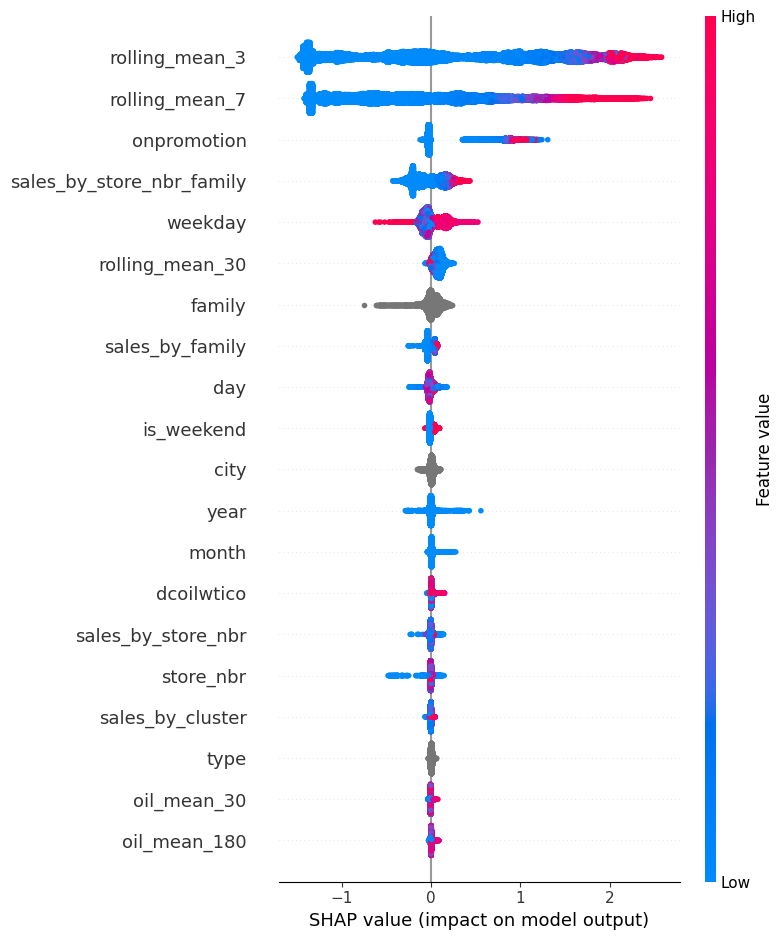

==== Fold 1 Individual Prediction SHAP ====


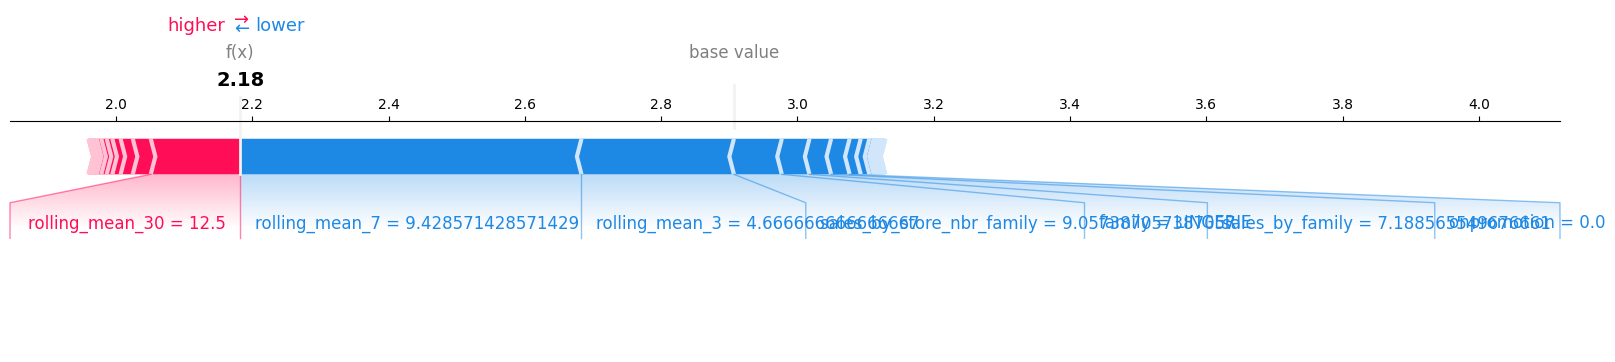

==== Fold 2 Summary SHAP ====


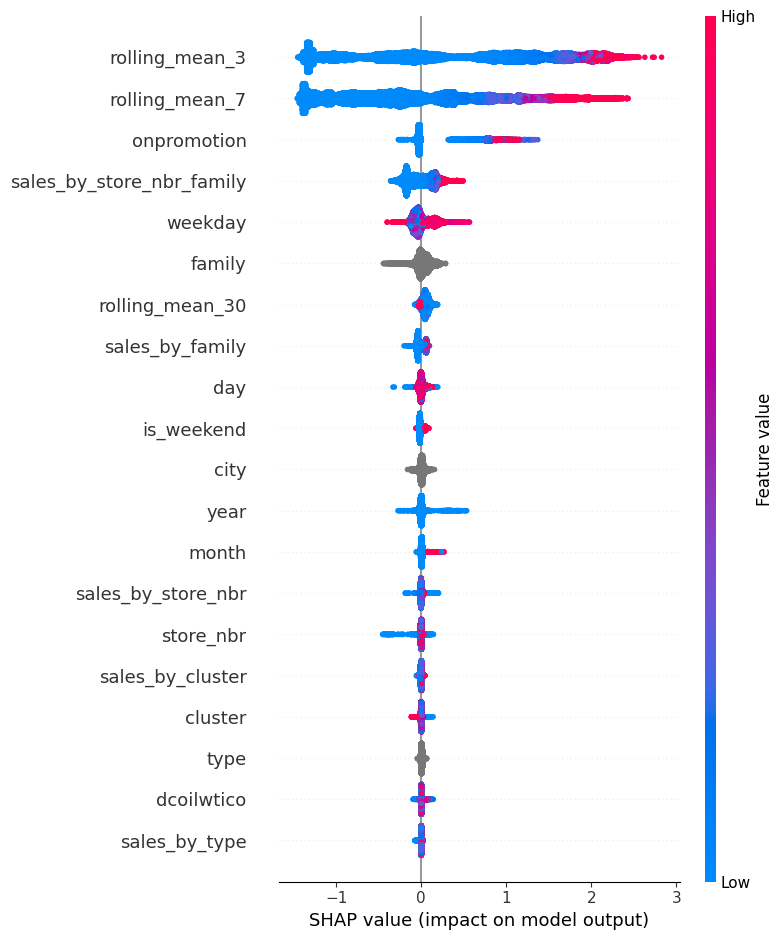

==== Fold 2 Individual Prediction SHAP ====


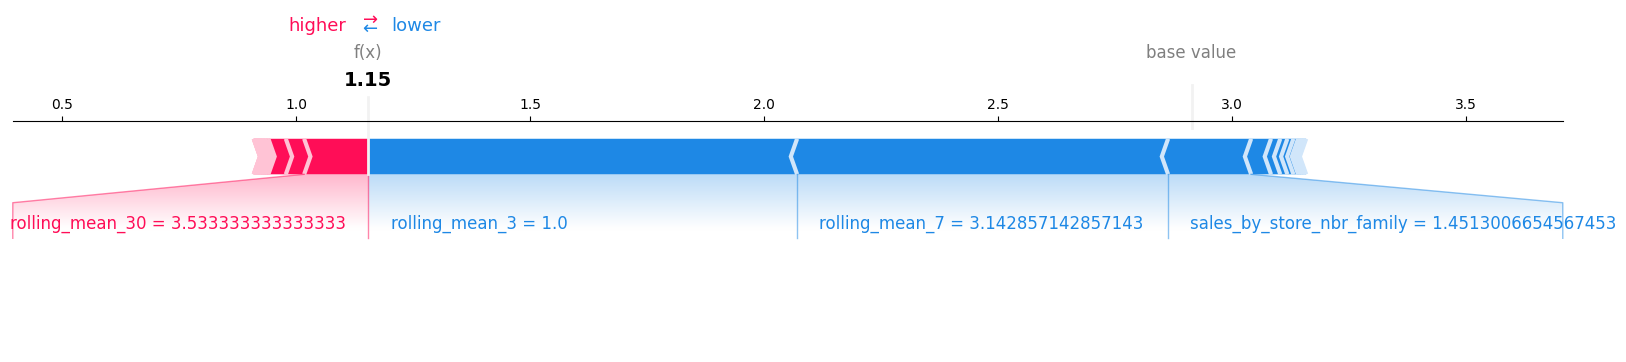

==== Fold 3 Summary SHAP ====


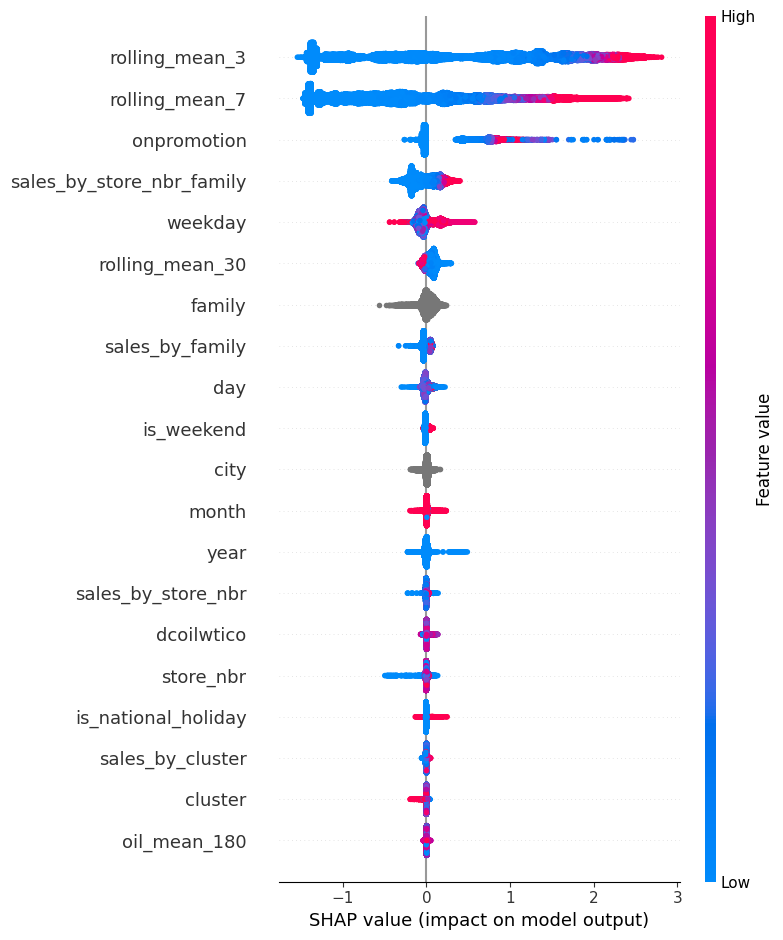

==== Fold 3 Individual Prediction SHAP ====


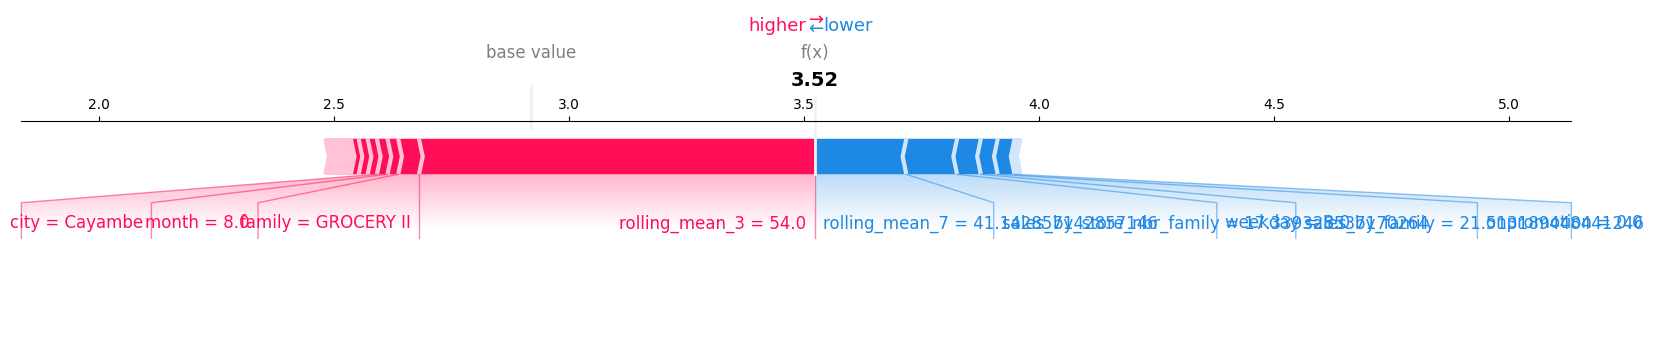

SHAP重要度を保存しました: /content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/shap_avg/shap_importance.pkl


In [ ]:
# 出力用フォルダ
output_dir = "/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/shap_avg"
os.makedirs(output_dir, exist_ok=True)

# ------------------------------
# 各foldモデルのSHAP解析と可視化
# ------------------------------
shap_values_list = []  # 後で平均SHAPを作る用

shap_calculate = True

if shap_calculate:

  for i in range(len(folds)):

      #読み込むモデルのファイルパス
      modelpath = "/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/models/model_lgb_base_fold{}.pickle".format(i+1)

      # モデル読み込み
      with open(modelpath, "rb") as f:
          model = pickle.load(f)

      # 検証データ
      X_val = X_vals_without_cnn[i]

      # SHAP解析
      #各行の各特徴量ごとにSHAP値を計算
      explainer = shap.TreeExplainer(model)
      shap_values = explainer.shap_values(X_val)
      shap_values_list.append(shap_values)

      # FoldごとのSummary Plot
      print(f"==== Fold {i+1} Summary SHAP ====")
      shap.summary_plot(shap_values, X_val)

      # ---- 個別予測 Force Plot ----
      example_idx = np.random.choice(len(X_val))
      print(f"==== Fold {i+1} Individual Prediction SHAP ====")
      shap.force_plot(
          explainer.expected_value,
          shap_values[example_idx,:],
          X_val.iloc[example_idx,:],
          matplotlib=True  # Jupyterで表示
      )

  # ------------------------------
  # 平均SHAP（近似）の作成
  # ------------------------------
  imp_list = []

  # 各foldのSHAP値を順番に取り出す
  for shap_vals in shap_values_list:
      # 各特徴量ごとにSHAP値の平均を算出
      imp = np.mean(np.abs(shap_vals), axis=0)
      imp_list.append(imp)

  # foldごとに各特徴量の平均SHAP値をimp_listに格納してあるので、その平均をとることで、
  # 全foldの各特徴量の平均を算出。どのfoldでも安定して効いていた特徴量を確認
  mean_abs_shap = np.mean(imp_list, axis=0)

  shap_imp_df = pd.DataFrame({
      "feature": FEATURES,
      "mean_abs_shap": mean_abs_shap
  }).sort_values("mean_abs_shap", ascending=False)


  # ------------------------------
  # 平均SHAPの保存（Streamlit用）
  # ------------------------------
  with open(os.path.join(output_dir, "shap_importance.pkl"), "wb") as f:
      pickle.dump(shap_imp_df, f)

  print(f"SHAP重要度を保存しました: {output_dir}/shap_importance.pkl")

In [ ]:
shap_imp_df


,feature,mean_abs_shap
26,rolling_mean_3,1.034142
27,rolling_mean_7,0.754282
2,onpromotion,0.332370
25,sales_by_store_nbr_family,0.141031
14,weekday,0.085304
28,rolling_mean_30,0.066245
1,family,0.052614
22,sales_by_family,0.040900
13,day,0.025980
15,is_weekend,0.019498


# 結果の保存

In [101]:
# 結果と条件の保存

save_experiment(
    exp_name="Version_without_oil-and-holiday-related-features_",
    features=FEATURES,
    params=params_without_cnn,
    df_metrics=df_metrics_without_cnn,
    df_imp_mean=df_imp_mean_without_cnn,
    shap_imp_df=None,
    use_cnn=False
)


✅ Experiment saved to: /content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/experiments/Version_without_oil-and-holiday-related-features__20260106_033405


# テストデータ作成

- 検証データでの比較より、今回はCNNなしとCNNありでほとんど結果に違いがなかったため、より計算コストなどが低いCNNなしバージョンを採用する

## foldに依存しない特徴量を作成

In [102]:
# テストデータでは、テスト期間である8/16よりも前の全期間でのデータを使ってモデルを学習するので、この期間を設定
FINAL_TRAIN_END = "2017-08-15"
TEST_END = "2017-08-31"

In [103]:
# train+test結合済みのdf
df_test_base = df.copy()
holidays_test_base = holidays.copy()


df_test_base = add_oil_features(df_test_base)
df_test_base = add_date_features(df_test_base)

holidays_test_base, regional_test_base, national_test_base, local_test_base, workday_test_base = make_holiday_flag(holidays_test_base)
df_test_base = add_holiday_flag(
    df_test_base,
    regional_test_base,
    national_test_base,
    local_test_base,
    workday_test_base
)


## foldに依存する特徴量を作成

In [104]:
# 平均系特徴量作成
for col in ["store_nbr", "family", "type", "cluster"]:
    df_test_base = sales_by_column(
        df_test_base, col, train_end=FINAL_TRAIN_END
    )

df_test_base = sales_by_columns(
    df_test_base, "store_nbr", "family", train_end=FINAL_TRAIN_END
)


In [105]:
# 移動平均作成
df_test_base = make_rolling_features(
    df_test_base,
    group_cols=["store_nbr", "family"],
    train_end=FINAL_TRAIN_END,
    val_end=TEST_END,
    windows=(3, 7, 30)
)


## 最終学習用の学習データとテストデータに分割

In [106]:
df_train_final = df_test_base[df_test_base["date"] <= FINAL_TRAIN_END].copy()
df_test = df_test_base[df_test_base["date"] >= "2017-08-16"].copy()


In [107]:
# 最終学習用の学習データを説明変数と目的変数で分割
X_train_final = df_train_final[FEATURES]
y_train_final = np.log1p(df_train_final["sales"])

# テストデータの説明変数を切り出す
X_test = df_test[FEATURES]


# 最終学習用の学習データでのモデル学習

In [108]:
models = []

for i in range(len(folds)):
  modelpath = f"/content/drive/MyDrive/データサイエンス個人学習/Kaggle&Signate/store sales コンペ/models/model_lgb_base_fold{i+1}.pickle"

  with open(modelpath, "rb") as f:
    saved_model = pickle.load(f)
    models.append(saved_model)

In [109]:
model_final = lgb.LGBMRegressor(**params_without_cnn) #ここはどのパラメータを使用するのかに応じて変更
model_final.fit(X_train_final, y_train_final)

# 最終モデルを追加
models_with_final = models + [model_final]


In [110]:
assert set(FEATURES) == set(X_train_final.columns)
assert set(FEATURES) == set(X_test.columns)


# テストデータでの予測

In [111]:
# final model
# expm1を使用し、対数化されている値をもとに戻す
final_pred = np.expm1(model_final.predict(X_test))

# ensemble
ensemble = True

if ensemble:
   ensemble_pred = np.expm1(np.mean([m.predict(X_test) for m in models_with_final], axis=0))


# 提出用ファイル作成

In [112]:
# 最終１モデルバージョン
df_submit = pd.DataFrame({
    "id": df_test["id"],
    "sales": final_pred
}).sort_values("id")

# アンサンブルバージョン
df_submit_ensemble = pd.DataFrame({
    "id": df_test["id"],
    "sales": ensemble_pred
}).sort_values("id")

df_submit.to_csv("submission.csv", index=False)

df_submit_ensemble.to_csv("submission_ensemble.csv", index=False)
